In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

from tqdm import tqdm
import os 

tqdm.pandas()

# my Helper functions

from HelperFunctions import *

import xgboost as xgb 
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import yellowbrick.model_selection as ms

In [36]:
landsat_train_data = '../Datasets/landsat_features_more_bands_train.csv'
landsat_validation_data = '../Datasets/landsat_features_more_bands_validation.csv'


In [ ]:
csv_training_files = ['../Datasets/landsat_features_more_bands_train.csv',
                          '../Datasets/terraclimate_features_more_bands_training.csv',
                          '../Datasets/nasa_precip_features_training.csv',
                          '../Datasets/soil_use_data_training.csv',
                          '../Datasets/nasa_terrain_features_training.csv',
                          '../Datasets/water_quality_training_dataset.csv']

target_columns = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']

drop_features = ['tmax', 'tmin', 'pct_urban', 'pct_water', 'pct_wetlands', 'pct_others', 'curvature', 'pet']
columns_to_drop_from_features = ["Latitude", "Longitude", "Sample Date"] + drop_features

dataHandler = DataOrganizer(target_columns)
dataHandler.load_training_data(csv_training_files, columns_to_drop_from_features)
#dataHandler.get_feature_columns()

In [115]:

Feature_data, Target_data = dataHandler.get_training_dataset()


alkalinity_target = Target_data['Total Alkalinity']
electrical_target = Target_data['Electrical Conductance']
phosphorus_target = Target_data['Dissolved Reactive Phosphorus']

X_train_alkalinity, X_test_alkalinity, y_train_alkalinity, y_test_alkalinity = train_test_split(Feature_data, alkalinity_target, test_size=0.15)
X_train_electrical, X_test_electrical, y_train_electrical, y_test_electrical = train_test_split(Feature_data, electrical_target, test_size=0.15)
X_train_phosphorus, X_test_phosphorus, y_train_phosphorus, y_test_phosphorus = train_test_split(Feature_data, phosphorus_target, test_size=0.15)

X_train_alkalinity


,nir,green,swir16,swir22,coastal,blue,red,lwir11,NDMI,MNDWI,...,Saline_Index,Runoff_Ratio,Chemical_Solubility,rain_7d_nasa,rain_3d_nasa,rain_12d_nasa,pct_natural,slope,month_sin,year_sin
5014,18201.5,9625.5,14269.0,11184.5,8328.0,8549.0,9149.5,47340.0,0.121110,-0.194333,...,0.367241,0.049367,24.640000,65.10,31.05,95.65,82.201788,3.016961,-2.449294e-16,0.587785
8263,15445.0,9343.0,13390.0,11024.0,8071.5,8341.5,9278.0,42806.0,0.071268,-0.178023,...,0.965768,0.050000,25.165000,70.28,61.84,110.48,51.795536,2.134300,-8.660254e-01,-0.587785
5559,31148.5,65535.0,29979.5,27027.0,NaN,65535.0,65535.0,NaN,0.019124,0.372252,...,-0.065324,0.050243,21.885000,9.95,7.50,42.18,57.240545,3.016961,1.000000e+00,-0.587785
2751,8372.5,10982.0,7718.0,7656.0,NaN,9476.0,10421.0,NaN,0.040676,0.174545,...,0.790329,0.049296,27.215000,0.17,0.17,0.17,58.117853,0.000000,-1.000000e+00,0.951057
4133,10576.5,9771.0,9559.5,8877.5,NaN,8966.0,9912.5,NaN,0.050507,0.010941,...,0.457507,0.049608,24.164999,0.00,0.00,0.00,71.827530,3.016961,1.224647e-16,0.587785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8962,10708.0,8036.0,9522.0,8719.0,7037.0,7327.0,8032.0,42205.0,0.058626,-0.084634,...,0.860492,0.049180,21.890000,16.55,0.16,23.49,92.620328,24.748625,-8.660254e-01,-0.951057
6634,13300.5,9264.5,13277.0,11481.0,8184.5,8506.0,9500.0,44924.0,0.000884,-0.178005,...,0.377306,0.050370,24.025000,0.06,0.00,1.74,97.184056,10.759584,-1.000000e+00,-0.587785
4824,13368.0,10505.0,12771.5,11341.0,NaN,9525.0,11206.5,NaN,0.022820,-0.097373,...,0.398261,0.050578,22.189999,14.03,0.11,38.68,71.335131,3.931096,-5.000000e-01,0.587785
5825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000320,0.049936,20.119999,1.33,0.26,2.17,55.248572,2.698951,8.660254e-01,-0.587785


## Feature Importance

In [ ]:
model_params = {
    'objective' :'reg:squarederror',
    'booster':'dart',
    'learning_rate' : 0.05, # bom
    'max_depth' : 5, # bom, muda comforme adicionar dados 
    'n_estimators' : 90, # bom, muda conforme adicionar dados
    'subsample' : 0.6,
    'colsample_bytree' : 0.5,
    'min_child_weight' : 10.0, ## fixado assim, bom
    'gamma' : 1.5,  ## fixado assim, bom
    'verbosity' : 1,
    'rate_drop' : 0.25, # bom : 0.25
    'skip_drop' : 0.5, # bom : 0.5
    
    'reg_lambda' : 18.0,                # L2 >= 0
    'reg_alpha' : 12.0,
}

dart_xgb_alcalinity= xgb.XGBRegressor(**model_params)

dart_xgb_electrical= xgb.XGBRegressor(**model_params)


dart_xgb_phosphorus= xgb.XGBRegressor(**model_params)

# parametros treino:


In [120]:

dart_xgb_alcalinity.fit(X_train_alkalinity, y_train_alkalinity,
            eval_set=[(X_test_alkalinity, y_test_alkalinity)])

dart_xgb_electrical.fit(X_train_electrical, y_train_electrical,
            eval_set=[(X_test_electrical, y_test_electrical)])

dart_xgb_phosphorus.fit(X_train_phosphorus, y_train_phosphorus,
            eval_set=[(X_test_phosphorus, y_test_phosphorus)])

[0]	validation_0-rmse:72.67387
[1]	validation_0-rmse:72.13038
[2]	validation_0-rmse:71.33130
[3]	validation_0-rmse:70.79968
[4]	validation_0-rmse:70.08657
[5]	validation_0-rmse:69.73837
[6]	validation_0-rmse:69.00665
[7]	validation_0-rmse:68.88027
[8]	validation_0-rmse:68.17158
[9]	validation_0-rmse:67.50775
[10]	validation_0-rmse:67.00277
[11]	validation_0-rmse:66.62601
[12]	validation_0-rmse:65.91651
[13]	validation_0-rmse:65.54622
[14]	validation_0-rmse:65.20659
[15]	validation_0-rmse:64.92277
[16]	validation_0-rmse:64.61674
[17]	validation_0-rmse:64.52535
[18]	validation_0-rmse:64.42866
[19]	validation_0-rmse:64.22020
[20]	validation_0-rmse:63.80747
[21]	validation_0-rmse:63.79284
[22]	validation_0-rmse:63.73984
[23]	validation_0-rmse:63.70550
[24]	validation_0-rmse:63.68678
[25]	validation_0-rmse:63.46565
[26]	validation_0-rmse:63.44044
[27]	validation_0-rmse:63.41177
[28]	validation_0-rmse:62.94843
[29]	validation_0-rmse:62.86051
[30]	validation_0-rmse:62.58348
[31]	validation_0-

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,'dart'
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.5
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabete

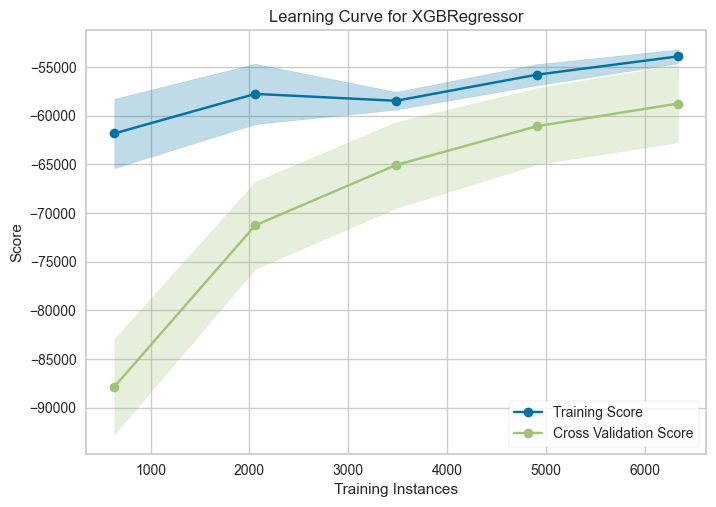

In [121]:
_ = ms.learning_curve(dart_xgb_electrical, X_train_electrical, y_train_electrical, scoring='neg_mean_squared_error', cv=5)

<Axes: >

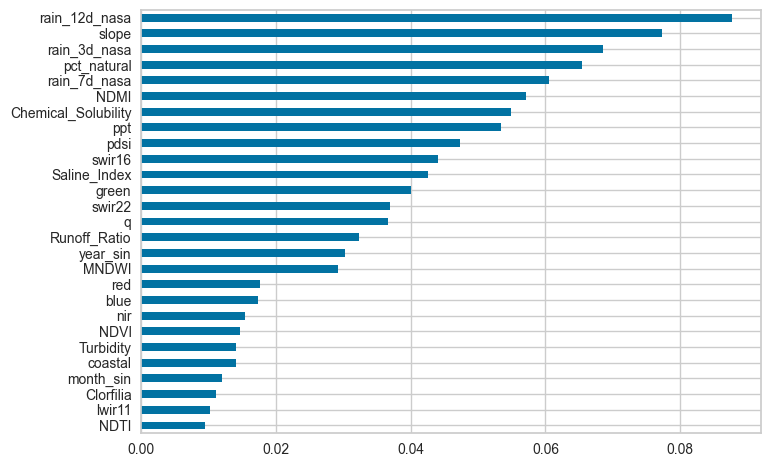

In [122]:
(pd.Series(dart_xgb_alcalinity.feature_importances_, index = X_train_alkalinity.columns).sort_values().plot.barh())


<Axes: >

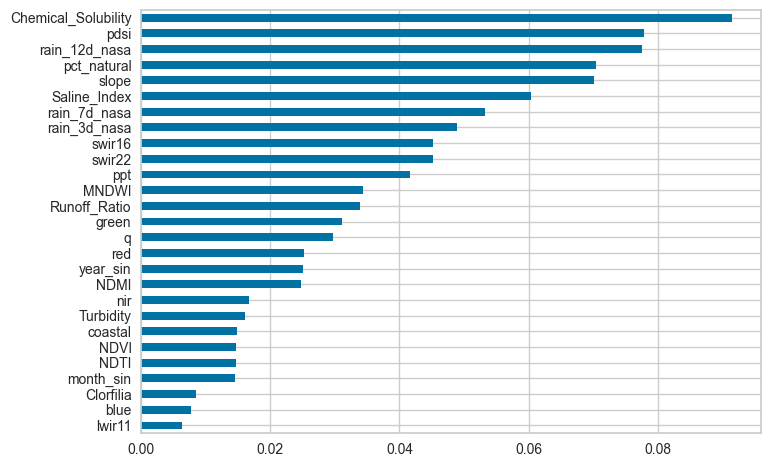

In [123]:

(pd.Series(dart_xgb_electrical.feature_importances_, index = X_train_electrical.columns).sort_values().plot.barh())


<Axes: >

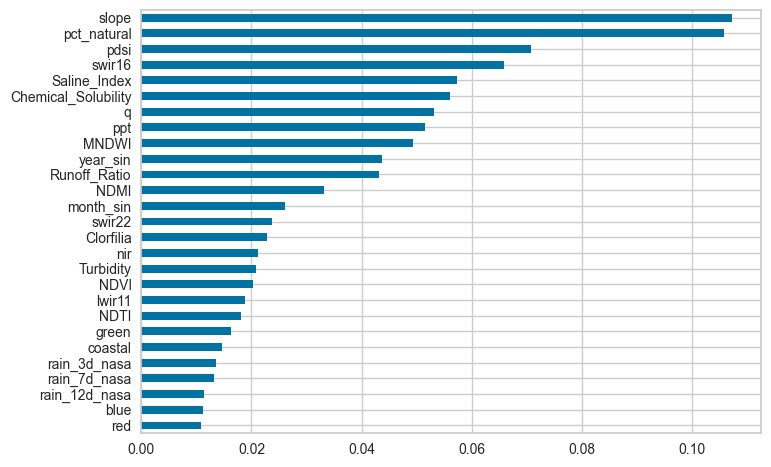

In [124]:

(pd.Series(dart_xgb_phosphorus.feature_importances_, index = X_train_phosphorus.columns).sort_values().plot.barh())

In [125]:
#make the print in green
print("\033[92mavaliando fosforo\033[0m")
evaluate_model(dart_xgb_phosphorus.predict(X_train_phosphorus), y_train_phosphorus, "train evaluation")
evaluate_model(dart_xgb_phosphorus.predict(X_test_phosphorus), y_test_phosphorus, "test evaluation")

print()
print("\033[92mavaliando alcalinidade\033[0m")
evaluate_model(dart_xgb_alcalinity.predict(X_train_alkalinity), y_train_alkalinity, "train evaluation")
evaluate_model(dart_xgb_alcalinity.predict(X_test_alkalinity), y_test_alkalinity, "test evaluation")

print()
print("\033[92mavaliando condutividade eletrica\033[0m")
evaluate_model(dart_xgb_electrical.predict(X_train_electrical), y_train_electrical, "train evaluation")
evaluate_model(dart_xgb_electrical.predict(X_test_electrical), y_test_electrical, "test evaluation")

avaliando fosforo

train evaluation Evaluation:
R²: 0.479
RMSE: 36.654

test evaluation Evaluation:
R²: 0.481
RMSE: 37.406

avaliando alcalinidade

train evaluation Evaluation:
R²: 0.562
RMSE: 49.613

test evaluation Evaluation:
R²: 0.521
RMSE: 50.752

avaliando condutividade eletrica

train evaluation Evaluation:
R²: 0.552
RMSE: 228.760

test evaluation Evaluation:
R²: 0.506
RMSE: 240.273


(array([521.82104, 343.84277, 646.4847 , ..., 585.505  , 414.3892 ,
        679.7444 ], dtype=float32),
 0.5058508873748793,
 np.float64(240.2727732309928))

## Submission

In [126]:
submission_csv_files = ['../Datasets/landsat_features_more_bands_validation.csv',
                          '../Datasets/terraclimate_features_more_bands_validation.csv',
                          '../Datasets/nasa_precip_features_validation.csv',
                          '../Datasets/soil_use_data_validation.csv',
                          '../Datasets/nasa_terrain_features_validation.csv']

dataHandler.load_submission_data(submission_csv_files)
all_submission_data = dataHandler.get_submission_dataset()

In [127]:

X_pred_input_features = all_submission_data

y_submission_pred_alkalinity = dart_xgb_alcalinity.predict(X_pred_input_features)
y_submission_pred_electrical = dart_xgb_electrical.predict(X_pred_input_features)
y_submission_pred_phosphorus = dart_xgb_phosphorus.predict(X_pred_input_features)

predicted_values_dict = {
    'Total Alkalinity': y_submission_pred_alkalinity, 
    'Electrical Conductance': y_submission_pred_electrical, 
    'Dissolved Reactive Phosphorus': y_submission_pred_phosphorus
}


predicted_pd_final = dataHandler.build_get_submission_dataset(predicted_values_dict)

predicted_pd_final.to_csv("../Results/submission_predictions_boosted_more_data.csv", index=False)
